Networks and Word Vectors with MeSH Labels
==========================================

In [1]:
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
import graph_tool.all as gt

/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/site-packages/graph_tool/draw/cairo_draw.py:1499: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [3]:
import os
import ast
import json
import itertools

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from datetime import datetime
from itertools import zip_longest
from matplotlib.ticker import NullFormatter

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool

from analysis.src.data.readnwrite import get_data_dir
from analysis.src.data.data_utilities import flatten, eval_column, grouper

pd.options.display.max_columns = 99
output_notebook()

Loading BokehJS ...

In [6]:
from graph_tool.centrality import eigenvector
from gensim.corpora import Dictionary

In [7]:
from graph_tool.draw import graph_draw

In [8]:
%matplotlib inline

# Paths
# Get the top path
data_path = get_data_dir()

# Create the path for external data
ext_data = os.path.join(data_path, 'external')
# Raw data
raw_data = os.path.join(data_path, 'raw')
# And external data
proc_data = os.path.join(data_path, 'processed')
# And interim data
inter_data = os.path.join(data_path, 'interim')
# And figures
fig_path = os.path.join(data_path, 'figures')

# Get date for saving files
today = datetime.utcnow()

today_str = "_".join([str(x) for x in [today.year,today.month,today.day]])

## 1. Load Data

We are going to load both the GDB and the RWJF Pioneer and Global projects, and join them into a single dataframe.

In [9]:
gdb_df = pd.read_csv(os.path.join(raw_data, 'gdb.csv'))

/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,5,7,10,11,12,13,14,18,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
rwjf_df = pd.read_csv(os.path.join(inter_data, 'rwjf_pioneer_and_global_projects.csv'))

Now we need to join the other relevant data modules:

Dates for GDB:

In [11]:
gdb_dates_df = pd.read_csv(os.path.join(inter_data, 'gdb_dates.csv'))
gdb_df = pd.concat([gdb_df, gdb_dates_df], axis=1)

MeSH labels:

In [12]:
gdb_mesh_df = pd.read_csv(os.path.join(inter_data, 'gdb_mesh_labels.csv'))
rwjf_mesh_df = pd.read_csv(os.path.join(inter_data, 'rwjf_mesh_labels.csv'))

gdb_df = pd.concat([gdb_df, gdb_mesh_df], axis=1)
rwjf_df = pd.concat([rwjf_df, rwjf_mesh_df], axis=1)

We're going to remove projects from GitHub as they don't play nicely with MeSH terms, and Crunchbase as they're very short. There are also some projects with null descriptions.

In [13]:
gdb_df = gdb_df[gdb_df['source_id'] != 'GitHub']
gdb_df = gdb_df[gdb_df['source_id'] != 'Crunchbase']
gdb_df['description'][pd.isnull(gdb_df['description'])] = ''

Let's concatenate the two sets of projects and extract their descriptions

In [14]:
gdb_df = pd.concat([gdb_df, rwjf_df], axis=0)
gdb_df.set_index('doc_id', inplace=True)
gdb_df = gdb_df.drop_duplicates(subset='description')

/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [15]:
descriptions = list(gdb_df['description'].values)

## Building a MeSH Label Corpus

We need to build a corpus of MeSH label transformed documents that is appropriate for the network we want to build. This will require some filtering, however first we should build a vocabulary of all the terms that we have, so that we can reference any of them by a unique ID at any time.

In [16]:
description_mesh_labels = eval_column(gdb_df, 'mesh_labels')

dictionary_mesh_labels = Dictionary(description_mesh_labels)

For filtering later, we will calculate the counts of the MeSH labels. We know already that there are some labels which are highly over-represented, and many which occur only once in the data.

In [29]:
mesh_label_counts = Counter(flatten(description_mesh_labels))

In [30]:
mesh_label_counts.most_common(20)

[('Students', 49316),
 ('Humans', 47839),
 ('Animals', 18113),
 ('Research', 17409),
 ('Goals', 16430),
 ('Universities', 16126),
 ('Research Personnel', 13132),
 ('United States', 12550),
 ('Female', 10022),
 ('Brain', 8834),
 ('Public Health', 7638),
 ('Child', 6428),
 ('Faculty', 5329),
 ('Mathematics', 5255),
 ('Awards and Prizes', 5209),
 ('HIV Infections', 5079),
 ('Fellowships and Scholarships', 4977),
 ('Polymers', 4968),
 ('Surveys and Questionnaires', 4793),
 ('Software', 4689)]

## Building a Sliding Window Coocurrence Network

From here we will want to create a new set of labelled descriptions where the terms with very high counts and little semantic value are removed, and also those that appear very few times in the corpus. We will also need to map the labels to token IDs which can then act as the vertex values in our graph.

In [31]:
def frequency_filter(docs, high_threshold=None, low_threshold=None, remove=[], counter=None):
    """freqency_filter
    Filters words from a corpus that occur more frequently than high_threshold
    and less frequently than low_threshold.
    
    Args:
        docs (:obj:`list` of :obj:`list`): Corupus of tokenised documents.
        high_threshold (int): Upper limit for token frequency
        low_threshold (int): Lower limit for token frequency
        remove (:obj:`list`): List of terms to remove
    
    Yields:
        doc_filtered (:obj:`list`): Document with elements removed based
            on frequency
    """
    docs_filtered = []
    if counter is None:
        counter = Counter(flatten(docs))
    for doc in docs:
        doc_filtered = []
        for t in doc:
            if t in remove:
                continue
            if high_threshold is not None:
                if counter[t] > high_threshold:
                    continue
            if low_threshold is not None:
                if counter[t] < low_threshold:
                    continue
            doc_filtered.append(t)
        docs_filtered.append(doc_filtered)
    return docs_filtered

In [32]:
def remove_repetitions(doc):
    """remove_repetitions
    Returns a modified list where there are no sequential repetitions.
    
    Args:
        doc (:obj:`list`): List of elements with sequential repetitions.
        
    Returns:
        doc (:obj:`list`): List of elements with no sequential repetitions.
    
    Examples:
        >>> doc = ['hi', 'hi', 'there', 'my', 'my', friend', 'friend', 'friend']
        
        >>> remove_repetitions(doc)
        ['hi', 'there', 'my', 'friend']
    """
    
    doc = [t[0] for t in itertools.groupby(doc)]
    return doc

print('remove_repetitions')

remove_repetitions


In [33]:
def window(seq, n=3):
    """window
    Returns a sliding window (of width n) over data from the iterable
       s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...
    """
    it = iter(seq)
    result = tuple(itertools.islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [34]:
def sliding_window_coocurrences(docs, n=3):
    coocurrences = []
    for doc in docs:
        doc_i = range(len(doc))
        doc_i = window(doc_i, n=n)
        doc_i = flatten([doc2coocurrences(t) for t in doc_i])
        doc = [sorted((doc[a], doc[b])) for a, b in list(set(doc_i))]
        doc = [tuple((a, b)) for a, b in doc if a !=b]
        coocurrences.append(doc)
    return coocurrences

In [35]:
def doc2coocurrences(doc):
    doc_combos = list(itertools.combinations(set(doc), r=2))
    doc_coocurrences = list(set([tuple(sorted(dc)) for dc in doc_combos]))
    return doc_coocurrences

In [36]:
def docs2coocurrences(docs):
    """docs2coocurrences
    Takes a set of documents and transforms each of them into a list
    of tuples, representing every term-term coocurrence in the 
    document.
    
    Args:
        docs (list of list of str): A list of tokenised documents.
    
    Returns:
        doc_coocurrences (list of list of tuple): A list of all documents
            transformed into term-term coocurrence tuples. Tuples are 
            sorted alphabetically.
            
    Examples:
        >>> pie_docs = [
                ['i', 'like', 'pie'],
                ['me', 'too'],
                ['i', 'like', 'it', 'more']
            ]
            
        >>> docs2coocurrences(pie_docs)
        [[('i', 'like'), ('i', 'pie'), ('like', 'pie')],
         [('me', 'too')],
         [('i', 'like'), ('i', 'it'), ('i', 'more'), ('like', 'it'), 
         ('like', 'more'), ('it', 'more')]
        ]
    """
    doc_coocurrences = []
    for d in docs:
        doc_combos = list(itertools.combinations(set(d), r=2))
        doc_combos = [tuple(sorted(dc)) for dc in doc_combos]
        doc_coocurrences.append(doc_combos)
    return doc_coocurrences

def edge_coocurrence_counts(doc_coocurrences):
    """coocurrence_counts
    Takes a corpus of document coocurrence combinations and returns a
    Counter object for them across the entire corpus.
    
    Args:
        doc_coocurrences (:obj:`list` of :obj:`list` of :obj:`tuple`): 
            Corpus of documents expressed as their coocurrence pairs.
            
    Returns:
        coocurrence_counts (:obj:`Counter`): Counter with keys as edges
            and values as number of coocurrences between the two vertices.
    """
    coocurrences = flatten(doc_coocurrences)
    coocurrence_counts = Counter(coocurrences)
    return coocurrence_counts

def vertex_degree_centralities(coocurrence_counts):
    """vertex_degree_centrality
    Takes a Counter of edge coocurrences and returns the degree centrality
    for each vertex.
    
    Args:
        coocurrence_counts (:obj:`Counter`): Counter with keys as edges
            and values as number of coocurrences between the two vertices.
            
    Returns: 
        vertex_degrees (:obj:`Counter`): Counter with keys as vertices
            and values as degree centralities.
    """
    vertex_degrees = Counter()
    for vertices, count in coocurrence_counts.items():
        v_0 = vertices[0]
        v_1 = vertices[1]
        if v_0 in vertex_degrees:
            vertex_degrees[v_0] += 1
        else:
            vertex_degrees[v_0] = 1
            
        if v_1 in vertex_degrees:
            vertex_degrees[v_1] += 1
        else:
            vertex_degrees[v_1] = 1
    return vertex_degrees

def vertex_coocurrence_centrality(coocurrence_counts):
    """vertex_coocurrence_centrality
    Takes a Counter of edge cooccurences and returns the coocurrence centrality
    for each vertex. This is a summation of all coocurrences for each vertex.
    
    Args:
        coocurrence_counts (:obj:`Counter`): Counter with keys as edges
            and values as number of coocurrences between the two vertices.
            
    Returns:
        vertex_coocurrences (:obj:`Counter`): Counter with keys as vertices
            and values as number of coocurrences.
    """
    
    vertex_coocurrences = Counter()
    for vertices, count in coocurrence_counts.items():
        v_0 = vertices[0]
        v_1 = vertices[1]
        if v_0 in vertex_coocurrences:
            vertex_coocurrences[v_0] += count
        else:
            vertex_coocurrences[v_0] = count
        if v_1 in vertex_coocurrences:
            vertex_coocurrences[v_1] += count
        else:
            vertex_coocurrences[v_1] = count
    return vertex_coocurrences

In [37]:
def association_strength(total_edges, n_coocurrences, coocurrence_count_0, coocurrence_count_1):
    association_strength = (2 * total_edges * n_coocurrences) / (coocurrence_count_0 * coocurrence_count_1)
    return association_strength

def mesh_label_association_strength(term_0, term_1):
    return association_strength(total_edges, coocurrence_counts[tuple(sorted([term_0, term_1]))],
                     mesh_label_id_coocurrence_counts[term_0],
                     mesh_label_id_coocurrence_counts[term_1])

def normalised_coocurrence_count(n_coocurrences, count_term_0, count_term_1):
    return n_coocurrences / (count_term_0 + count_term_1)

def mesh_label_normalised_coocurrence_count(term_0, term_1):
    n_cooc = coocurrence_counts[tuple(sorted([term_0, term_1]))]
    return normalised_coocurrence_count(n_cooc,
                                    mesh_label_deduped_id_counts[term_0],
                                    mesh_label_deduped_id_counts[term_1])

def jaccard_similarity(term_0, term_1, n):
    return n / (mesh_label_unique_counts[term_0] + mesh_label_unique_counts[term_1] - n)

In [38]:
descriptions_mesh_label_filtered = frequency_filter(description_mesh_labels, high_threshold=13000, low_threshold=5)
dictionary_filtered = Dictionary(descriptions_mesh_label_filtered)

descriptions_mesh_label_filtered_ids = [dictionary_filtered.doc2idx(dmlf) for dmlf in descriptions_mesh_label_filtered]

description_mesh_label_sliwi_coocurrences = sliding_window_coocurrences(descriptions_mesh_label_filtered_ids, n=3)

description_mesh_label_sliwi_edges = list(set(flatten(description_mesh_label_sliwi_coocurrences)))

In [39]:
sliwi_edge_coocurrence_counts = edge_coocurrence_counts(description_mesh_label_sliwi_coocurrences)
sliwi_vertex_degree_centralities = vertex_degree_centralities(sliwi_edge_coocurrence_counts)
sliwi_vertex_coocurrences_centralities = vertex_coocurrence_centrality(sliwi_edge_coocurrence_counts)

n_vertices = len(sliwi_vertex_degree_centralities)
n_edges = len(sliwi_edge_coocurrence_counts)
n_coocurrences = len(flatten(description_mesh_label_sliwi_coocurrences))

In [40]:
print('Total verticies: {:,}'.format(n_vertices))
print('Total edges: {:,}'.format(n_edges))
print('Total coocurrences: {:,}'.format(n_coocurrences))

Total verticies: 11,996
Total edges: 692,672
Total coocurrences: 1,868,742


In [41]:
sliwi_graph = gt.Graph(directed=False)
sliwi_graph.add_vertex(n_vertices)
sliwi_graph.add_edge_list(description_mesh_label_sliwi_edges)

In [57]:
# add association strengths
a_strength_sliwi_graph = sliwi_graph.new_edge_property("float")
a_strength_sliwi_graph.set_value(0)

for s, t in description_mesh_label_sliwi_edges:
    a_strength_sliwi_graph[sliwi_graph.edge(s, t)] = association_strength(
        n_coocurrences,
        sliwi_edge_coocurrence_counts[tuple(sorted([s, t]))],
        sliwi_vertex_coocurrences_centralities[s],
        sliwi_vertex_coocurrences_centralities[t])
    
sliwi_graph.edge_properties["association_strength"] = a_strength_sliwi_graph

In [94]:
a = [('rockets', 'and', 'moonshots'), ('and', 'moonshots', 'blame'), ('moonshots', 'blame', 'it'), ('blame', 'it', 'on'), ('it', 'on', 'the'), ('on', 'the', 'have'), ('the', 'have', 'nots')]
b = [('rockets', 'and', 'moonshots'),
     ('and', 'moonshots', 'blame'),
     ('moonshots', 'blame', 'it'),
     ('blame', 'it', 'on'),
     ('it', 'on', 'the'),
     ('on', 'the', 'have'),
     ('the', 'have', 'nots')
     ]

In [97]:
print(a)

[('rockets', 'and', 'moonshots'), ('and', 'moonshots', 'blame'), ('moonshots', 'blame', 'it'), ('blame', 'it', 'on'), ('it', 'on', 'the'), ('on', 'the', 'have'), ('the', 'have', 'nots')]


#### Node2Vec

In [36]:
with open(os.path.join(inter_data, 'sliwi_mesh_label_coocurrences_100.edgelist'), 'w') as f:
    for edge, assoc_strength in zip(sliwi_graph.edges(), a_strength_sliwi_graph.get_array()):
        s = int(edge.source())
        t = int(edge.target())
        if (s < 100) & (t < 100):
            w = '{} {} {}\n'.format(s, t, assoc_strength)
            f.write(w)

In [959]:
with open(os.path.join(inter_data, 'test_graph.edgelist'), 'w') as f:
    for edge in G.edges:
        s = '{} {}\n'.format(edge[0], edge[1])
        f.write(s)

In [38]:
from node2vec import Node2Vec

In [49]:
sliwi_graph_nx = nx.Graph()
sliwi_graph_nx.add_nodes_from(list(set(flatten(descriptions_mesh_label_filtered_ids))))
sliwi_graph_nx.add_edges_from(description_mesh_label_sliwi_edges)

In [53]:
node2vec_sliwi = Node2Vec(sliwi_graph_nx, dimensions=128,
                    walk_length=60, num_walks=16, workers=4,
                    p=1, q=2)
node2vec_model_sliwi = node2vec.fit(window=10, min_count=1, batch_words=4)

Computing transition probabilities: 100%|██████████| 11996/11996 [1:05:49<00:00,  3.04it/s]
/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:686: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
Traceback (most recent call last):
  File "/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/site-packages/joblib/externals/loky/backend/queues.py", line 157, in _feed
    send_bytes(obj)
  File "/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/multiprocessing/connection.py", line 393, in _send_bytes
    header = struct.pack("!i", n)
struct.error: 'i' format requires -2147483648 <= number <= 2147483

KeyboardInterrupt: 

## Sub-Graph Networks

### Building a Vocabulary

In [ ]:
mesh_label_deduped_counts = Counter(flatten(description_mesh_labels_deduped))

In [12]:
description_mesh_labels_deduped = [[m.lower() for m in list(set(ml))] for ml in description_mesh_labels]

In [14]:
description_mesh_duis = eval_column(gdb_df, 'mesh_duis')
description_mesh_duis_unique = [list(set(ml)) for ml in description_mesh_duis]

In [716]:
mesh_label_deduped_counts.most_common(20)

[('humans', 31234),
 ('goals', 12360),
 ('students', 11709),
 ('animals', 10412),
 ('united states', 8126),
 ('universities', 7822),
 ('female', 6973),
 ('research personnel', 6419),
 ('research', 5659),
 ('child', 4696),
 ('public health', 4673),
 ('awards and prizes', 3627),
 ('male', 3299),
 ('faculty', 2954),
 ('brain', 2509),
 ('surveys and questionnaires', 2455),
 ('software', 2360),
 ('water', 2249),
 ('mice', 2172),
 ('pregnancy', 2123)]

In [134]:
def filter_description_labels(description_labels, fn):
    return [list(filter(fn, dl)) for dl in description_labels]   

In [138]:
description_mesh_labels_deduped_filtered = filter_description_labels(description_mesh_labels_deduped,
                                            lambda x: x not in ['humans', 'goals', 'students', 'animals', 'universities',
                                            'research personnel', 'research', 'awards and prizes', 'faculty'])

In [140]:
from gensim.corpora import Dictionary

In [141]:
mesh_label_dictionary = Dictionary(description_mesh_labels_deduped_filtered)

# create a version of the MeSH label descriptions with IDs replacing their tokens
description_mesh_labels_deduped_ids = [mesh_label_dictionary.doc2idx(dmld) for dmld in description_mesh_labels_deduped_filtered]

# count the number of occurrences of each ID
mesh_label_deduped_id_counts = Counter(flatten(description_mesh_labels_deduped_ids))

In [456]:
x = [d for d in description_mesh_labels if 'Machine Learning' in d]

In [142]:
def document_token_edges(tokenised_descriptions):
    combinations = []
    for td in tokenised_descriptions:
        description_combos = list(itertools.combinations(set(td), r=2))
        description_combos = [tuple(sorted(dc)) for dc in description_combos]
        combinations.append(description_combos)
    return combinations

description_mesh_label_id_edge_list = document_token_edges(description_mesh_labels_deduped_ids)
mesh_label_id_edge_list = list(set(flatten(description_mesh_label_id_edge_list)))

In [143]:
coocurrence_counts = Counter(flatten(description_mesh_label_id_edge_list))

In [144]:
mesh_label_id_coocurrence_counts = {}

for k, v in coocurrence_counts.items():
    term_0 = k[0]
    term_1 = k[1]
    if term_0 in mesh_label_id_coocurrence_counts:
        mesh_label_id_coocurrence_counts[term_0] += v
    else:
        mesh_label_id_coocurrence_counts[term_0] = v
    if term_1 in mesh_label_id_coocurrence_counts:
        mesh_label_id_coocurrence_counts[term_1] += v
    else:
        mesh_label_id_coocurrence_counts[term_1] = v

In [146]:
total_labels = len(mesh_label_deduped_id_counts)
total_coocurrences = len(flatten(description_mesh_label_id_edge_list))
total_edges = len(coocurrence_counts)

print('Total number of terms: {:,}'.format(total_labels))
print('Total number of coocurrences: {:,}'.format(total_coocurrences))
print('Total number of edges: {:,}'.format(total_edges))

Total number of terms: 19,904
Total number of coocurrences: 3,844,286
Total number of edges: 1,882,297


In [149]:
def association_strength(total_edges, n_coocurrences, edge_count_0, edge_count_1):
    association_strength = (2 * total_edges * n_coocurrences) / (edge_count_0 * edge_count_1)
    return association_strength

def mesh_label_association_strength(term_0, term_1):
    return association_strength(total_edges, coocurrence_counts[tuple(sorted([term_0, term_1]))],
                     mesh_label_id_coocurrence_counts[term_0],
                     mesh_label_id_coocurrence_counts[term_1])

def normalised_coocurrence_count(n_coocurrences, count_term_0, count_term_1):
    return n_coocurrences / (count_term_0 + count_term_1)

def mesh_label_normalised_coocurrence_count(term_0, term_1):
    n_cooc = coocurrence_counts[tuple(sorted([term_0, term_1]))]
    return normalised_coocurrence_count(n_cooc,
                                    mesh_label_deduped_id_counts[term_0],
                                    mesh_label_deduped_id_counts[term_1])

def jaccard_similarity(term_0, term_1, n):
    return n / (mesh_label_unique_counts[term_0] + mesh_label_unique_counts[term_1] - n)

## Term Graph

We now have a series of documents described in terms of their MeSH labels. From this we can build a network to explore the connections between concepts, and try to understand how we might be able to find "innovative" combinations or terms in an unsupervised manner. For this network, nodes will be the terms themselves, while an edge being drawn between two nodes will represent that term pair appearing in at least one document together - a coocurrence.

- Node attributes:
    - count: total number of times the term appeared in the corpus (int)
    - count_normalised: count, normalised by the total number of terms in the corpus (float)
    - mesh_tree_codes: array of MeSH Tree Numbers (list)
    - edge_count: number of other nodes that this node is connected to (int)

In [150]:
term_graph = gt.Graph(directed=False)
term_graph.add_vertex(total_labels)
term_graph.add_edge_list(mesh_label_id_edge_list)

In [151]:
# add association strengths
association_strength_term_graph = term_graph.new_edge_property("double")

for s, t in mesh_label_id_edge_list:
    association_strength_term_graph[term_graph.edge(s, t)] = association_strength(
        total_edges,
        coocurrence_counts[tuple(sorted([s, t]))],
        mesh_label_id_coocurrence_counts[s],
        mesh_label_id_coocurrence_counts[t])
    
term_graph.edge_properties["association_strength"] = association_strength_term_graph

In [152]:
# add term frequencies
label_count_term_graph = term_graph.new_vertex_property("int")

for k, v in mesh_label_deduped_id_counts.items():
    label_count_term_graph[term_graph.vertex(k)] = v
    
term_graph.vertex_properties["label_count"] = label_count_term_graph

In [153]:
high_pass_filter_term_graph = term_graph.new_vertex_property("bool")

for k, v in mesh_label_deduped_id_counts.items():
    if v > 10:
        high_pass_filter_term_graph[term_graph.vertex(k)] = True
    else:
        high_pass_filter_term_graph[term_graph.vertex(k)] = False
        
term_graph.vertex_properties["high_pass_filter"] = high_pass_filter_term_graph

### Node2Vec

In [448]:
with open(os.path.join(inter_data, 'full_mesh_label_coocurrences.edgelist'), 'w') as f:
    for edge, assoc_strength in zip(term_graph.edges(), association_strength_term_graph.get_array()):
        s = '{} {} {}\n'.format(int(edge.source()), int(edge.target()), assoc_strength)
        f.write(s)

### Centrality Measures

In [176]:
from graph_tool.centrality import betweenness, closeness, katz

In [155]:
term_graph.list_properties()

high_pass_filter (vertex)  (type: bool)
label_count    (vertex)  (type: int32_t)
association_strength (edge)    (type: double)


In [156]:
term_graph_betweenness_nw = betweenness(term_graph)

In [178]:
term_graph_katz_nw = katz(term_graph, alpha=0.0001)

In [179]:
term_graph_closeness_nw = closeness(term_graph)

In [209]:
centrality_df = pd.DataFrame({'betweenness': bv_nw.get_array().astype('float32'),
                              'closeness': term_graph_closeness_nw.get_array().astype('float32'),
                              'katz': term_graph_katz_nw.get_array().astype('float32')})

In [218]:
centrality_df['closeness'][pd.isnull(centrality_df['closeness'])] = 0

In [223]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [220]:
tsne = TSNE()

In [221]:
centrality_tsne = tsne.fit_transform(centrality_df)

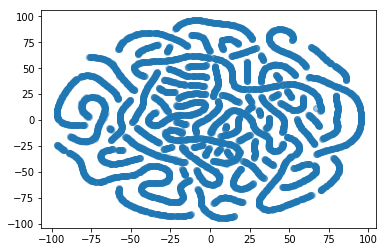

In [222]:
plt.scatter(centrality_tsne[:, 0], centrality_tsne[:, 1], alpha=0.1)
plt.savefig()

## Individual Term Sub-Graphs

In [269]:
def doctokens2graph(docs, dictionary):
    
    n_vertices = len(dictionary.keys())

    id_docs = [dictionary.doc2idx(d) for d in docs]
    id_coocurrences = docs2coocurrences(id_docs)
    id_edges = list(set(flatten(id_coocurrences)))

    graph = gt.Graph(directed=False)
    graph.add_vertex(n_vertices)
    graph.add_edge_list(id_coocurrences)
    
    return graph, id_edge_list

Build a graph for each subset of documents that contains a label. Calculate centrality and other measures for that label within its sub-graph.

In [376]:
sub_graph_centralities = {}

for label in mesh_label_dictionary.values():
    subset_descriptions = [d for d in description_mesh_labels_deduped_filtered if label in d]
    n_tokens = len(flatten(subset_descriptions))
    n_docs = len(subset_descriptions)
    dictionary = Dictionary(subset_descriptions)

    n_terms = len(dictionary.keys())

    label_id = dictionary.token2id[label]

    subset_description_ids = [dictionary.doc2idx(sd) for sd in subset_descriptions]
    subset_description_id_counts = Counter(flatten(subset_description_ids))

    subset_id_coocurrences = docs2coocurrences(subset_description_ids)
    subset_id_edge_list = list(set(flatten(subset_id_coocurrences)))
    n_edges = len(subset_id_edge_list)
    
    coocurrence_counts = edge_coocurrence_counts(subset_id_coocurrences)
    vertex_coocurrences = vertex_coocurrence_centrality(coocurrence_counts)
    
    sub_graph = gt.Graph(directed=False)
    sub_graph.add_vertex(n_terms)
    sub_graph.add_edge_list(subset_id_edge_list)
    
#     association_strength_sub_graph = sub_graph.new_edge_property("double")

#     for s, t in subset_id_edge_list:
#         association_strength_sub_graph[sub_graph.edge(s, t)] = association_strength(
#             n_edges,
#             coocurrence_counts[tuple(sorted([s, t]))],
#             vertex_coocurrences[s],
#             vertex_coocurrences[t])
    
#     sub_graph.edge_properties["association_strength"] = association_strength_sub_graph

    label_betweenness = betweenness(sub_graph)[0].get_array().astype('float32')[label_id]
    label_katz = katz(sub_graph, alpha=0.01).get_array().astype('float32')[label_id]
    label_global_cluster_coef = global_clustering(sub_graph)
#     label_betweenness = betweenness(sub_graph, weight=association_strength_sub_graph)[0].get_array().astype('float32')[label_id]
#     label_katz = katz(sub_graph, alpha=0.001, weight=association_strength_sub_graph).get_array().astype('float32')[label_id]
#     label_closeness = closeness(sub_graph).get_array().astype('float32')[label_id]

    n_edges = sub_graph.vertex(label_id).out_degree()

    sub_graph_centralities[label] = {'betweenness': label_betweenness,
                                     'katz': label_katz,
#                                      'closeness': label_closeness,
                                     'global_cluster_coef': label_global_cluster_coef[0],
                                     'global_cluster_std': label_global_cluster_coef[1],
                                     'n_vertices': n_terms,
                                     'n_edges': n_edges,
                                     'n_docs': n_docs,
                                     'n_tokens': n_tokens,
                                    }

/Users/grichardson/miniconda3/envs/python3.6.1/lib/python3.6/site-packages/graph_tool/centrality/__init__.py:783: RuntimeWarning: invalid value encountered in true_divide
  vprop.fa = vprop.fa / numpy.linalg.norm(vprop.fa)


In [378]:
sub_graph_centralities_df_weighted = pd.DataFrame.from_records(sub_graph_centralities).T
sub_graph_centralities_df_weighted = sub_graph_centralities_df_weighted[sub_graph_centralities_df_weighted['n_docs'] >= 5]

In [387]:
sub_graph_centralities_df_weighted['n_vertices_normed'] = sub_graph_centralities_df_weighted['n_vertices'] / sub_graph_centralities_df_weighted['n_docs']

In [390]:
sub_graph_centralities_df_weighted['lexical_richness'] = sub_graph_centralities_df_weighted['n_vertices'] / sub_graph_centralities_df_weighted['n_tokens']

In [391]:
sub_graph_centralities_df_weighted.head()

,betweenness,global_cluster_coef,global_cluster_std,katz,n_docs,n_edges,n_tokens,n_vertices,n_vertices_normed,lexical_richness
"1,2-di-(4-sulfamidophenyl)-4-butylpyrazolidine-3,5-dione",0.824296,0.686307,0.077660,0.103263,7.0,94.0,128.0,95.0,13.571429,0.742188
"1,3-butadiene",0.483213,0.681623,0.112713,0.085409,8.0,139.0,170.0,140.0,17.500000,0.823529
1-butanol,0.702747,0.657135,0.060893,0.097561,6.0,105.0,145.0,106.0,17.666667,0.731034
1-methyl-3-isobutylxanthine,0.997904,0.664376,0.225430,0.135586,6.0,54.0,64.0,55.0,9.166667,0.859375
"2',3'-cyclic-nucleotide phosphodiesterases",1.000000,0.653263,0.308410,0.172303,5.0,33.0,39.0,34.0,6.800000,0.871795


In [338]:
sub_graph_centralities_df = sub_graph_centralities_df[sub_graph_centralities_df['n_docs'] >= 5]
sub_graph_centralities_df['n_vertices_normed'] = sub_graph_centralities_df['n_vertices'] / sub_graph_centralities_df['n_docs']

In [356]:
sub_graph_centralities_df.head()

,betweenness,global_cluster_coef,global_cluster_std,katz,n_docs,n_edges,n_vertices,n_vertices_normed
"1,2-di-(4-sulfamidophenyl)-4-butylpyrazolidine-3,5-dione",0.291023,0.686307,0.077660,0.109682,7.0,94.0,95.0,13.571429
"1,3-butadiene",0.316229,0.681623,0.112713,0.093893,8.0,139.0,140.0,17.500000
1-butanol,0.147291,0.657135,0.060893,0.104333,6.0,105.0,106.0,17.666667
1-methyl-3-isobutylxanthine,0.696366,0.664376,0.225430,0.140557,6.0,54.0,55.0,9.166667
"2',3'-cyclic-nucleotide phosphodiesterases",0.774621,0.653263,0.308410,0.175776,5.0,33.0,34.0,6.800000


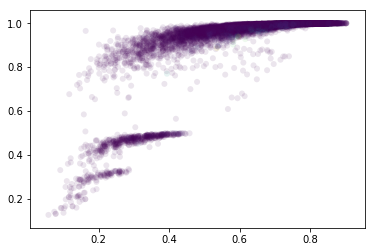

In [412]:
plt.scatter(sub_graph_centralities_df['betweenness'],
            sub_graph_centralities_df_weighted['betweenness'],
            alpha=0.1, edgecolor='none', 
            c=sub_graph_centralities_df_weighted['n_edges'])
plt.show()

### Old Network

In [ ]:
for mln in mesh_label_nodes:
    count = mesh_label_unique_counts[mln]
    graph_mesh_labels.add_node(
        mln,
        count=count,
        count_normalised=count / n_mesh_labels_unique,
        group_0=map_tree_group(
            mln, 
            mesh_label_dui_map, 
            dui_tree_number_map, 
            tree_level_0_map,
            level=0
        ),
        group_1=map_tree_group(
            mln, 
            mesh_label_dui_map, 
            dui_tree_number_map, 
            tree_level_1_map
        )
    )

Each node is connected to another node by an edge when they coocurr in at least one document. However, this provides no information about how often different labels coocurr with each other. To account for this, we will provide a choice of weights for the edges. The first is the raw number of coocurrences across the corpus. We then also calculate the Jaccard index and the association strength as defined in Waltman _et al_.  2009 and Noyons _et al_. 2010 respectively.

- Edge attributes
    - weight_absolute: number of documents in which terms coocur (int)
    - jaccard_similarity: number between 0 and 1 representing the Jaccard Index of terms (float)
    - association_strength: association strength score of terms (float)

In [ ]:
description_mesh_label_combinations = []
for ml in description_mesh_labels_unique:
    mesh_label_doc = list(itertools.combinations(set(ml), r=2))
    mesh_label_doc = [tuple(sorted(mld)) for mld in mesh_label_doc]
    description_mesh_label_combinations.append(mesh_label_doc)

In [ ]:
edge_coocurrence_counts = Counter(flatten(description_mesh_label_combinations))

In [ ]:
mesh_label_coocurrence_count_map = defaultdict(dict)

for ml, c in edge_coocurrence_counts.items():
    n0 = ml[0]
    n1 = ml[1]
    mesh_label_coocurrence_count_map[n0][n1] = c
    mesh_label_coocurrence_count_map[n1][n0] = c

In [ ]:
n_coocurrences = len(flatten(description_mesh_label_combinations))
n_edges = len(edge_coocurrence_counts)

In [ ]:
print('Number of Co-occurrences:', n_coocurrences)
print('Number of Edges:', n_edges)
print('Mean Co-occurences per Edge:', n_coocurrences / n_edges)

In [ ]:
mesh_label_coocurrence_counts = {}
mesh_label_edge_counts = {}

for ml, co in mesh_label_coocurrence_count_map.items():
    coocurrence_count = sum([n for n in co.values()])
    edge_count = len(co)
    mesh_label_edge_counts[ml] = edge_count
    mesh_label_coocurrence_counts[ml] = coocurrence_count

mesh_label_coocurrence_counts = Counter(mesh_label_coocurrence_counts)
mesh_label_edge_counts = Counter(mesh_label_edge_counts)

In [ ]:
print_counter_extremes(mesh_label_coocurrence_counts)

In [ ]:
print_counter_extremes(mesh_label_edge_counts)

In [ ]:
for edge, count in edge_coocurrence_counts.items():
    node_0 = edge[0]
    node_1 = edge[1]
    graph_mesh_labels.add_edge(node_0, node_1,
                               coocurrences_absolute=count,
                               jaccard_similarity=jaccard_similarity(node_0,
                                                                     node_1,
                                                                     count),
                               association_strength=coocurrence_association_strength(node_0,
                                                                                     node_1,
                                                                                     count))

In [ ]:
with open(proc_data + 'mesh_term_raw_graph.json', 'w') as f:
    json.dump(nx.node_link_data(graph_mesh_labels), f)

Let's have a look at the edge attributes for the most common and some of the least common coocurrences.

In [ ]:
top_n = 20

print('{:<30}\t{:<8}\t{:30}\t{:<8}\t{:<15}\t{}\t{}\n'.format(
    'Node 0', 'Count 0', 'Node 1', 'Count 1', 'Cooccurences',
    'Jaccard Index', 'Association Strength'))

for l, n in edge_coocurrence_counts.most_common(top_n):
    term_0 = l[0]
    term_1 = l[1]
    c0 = mesh_label_unique_counts[term_0]
    c1 = mesh_label_unique_counts[term_1]
    j = jaccard_similarity(term_0, term_1, n)
    a = coocurrence_association_strength(term_0, term_1, n)
    print('{:<30}\t{:<8}\t{:30}\t{:<8}\t{:<15}\t{:.2f}\t{:12.2f}'.format(l[0], c0, l[1], c1, n, j, a))
    
print('...')

low_counts = {k: v for k, v in edge_coocurrence_counts.items() if v <= 3}
low_count_keys_n = list(itertools.islice(low_counts, top_n))
low_counts_n = [(k, low_counts[k]) for k in low_count_keys_n]

for l, n in low_counts_n:
    term_0 = l[0]
    term_1 = l[1]
    c0 = mesh_label_unique_counts[term_0]
    c1 = mesh_label_unique_counts[term_1]
    j = jaccard_similarity(term_0, term_1, n)
    a = coocurrence_association_strength(term_0, term_1, n)
    print('{:<30}\t{:8}\t{:30}\t{:<8}\t{:<15}\t{:.2f}\t{:12.2f}'.format(l[0], c0, l[1], c1, n, j, a))

print('\n')

We can see that edges representing high numbers of coocurrences are unsurprisingly drawn between terms that have a high count across the corpus. Interestingly, the terms with the highest number of coocurrences are not the two that have the highest frequency (_Humans_ and _Students_). We can see that for the top terms, the Jaccard similarity hovers at the lower end of the range. We can see how it is modulated by both the number of coocurrences, but also the individual term frequencies. At the lower end of the coocurrence counts, we can see connected terms that exhibit a Jaccard index of only 0.01 or less. The association strength however shows a large degree of variation, in part due to its inherent nature of not being bounded between finite limits. The range of values among the most highly occurring terms and the less frequent terms are more consistent too. However, it can be seen that terms with lower frequencies can exhibit much higher association strengths, as their low counts reduces the chances of them coocurring "by chance".

In [55]:
# create a mapping from the MeSH labels the their unique IDs
mesh_label_dui_map = {}

for labels, duis in zip(description_mesh_labels_unique, description_mesh_duis_unique):
    for label, dui in zip(labels, duis):
        if label not in mesh_label_dui_map:
            mesh_label_dui_map[label] = dui

In [58]:
with open(os.path.join(inter_data, 'mesh_ontology', 'mesh_descriptions.json'), 'r') as f:
    mesh_label_ontology = json.load(f)

In [59]:
# create a mapping from the MeSH label unique IDs to their MeSH Tree number
dui_tree_number_map = {}

for descriptor in mesh_label_ontology['DescriptorRecordSet']['DescriptorRecord']:
    tree_number = descriptor.get('TreeNumberList')
    if tree_number is not None:
        tree_number = tree_number.get('TreeNumber')
    if isinstance(tree_number, list):
        dui_tree_number_map[descriptor['DescriptorUI']] = tree_number
    else:
        dui_tree_number_map[descriptor['DescriptorUI']] = [tree_number]

In [65]:
# map of 0th level MeSH Tree codes to their semantic representations
tree_level_0_map = {
    'A': 'anatomy',
    'B': 'organisms',
    'C': 'diseases',
    'D': 'chemicals and drugs',
    'E': 'analytical, diagnostic, and therapeutic techniques, and equipment',
    'F': 'psychiatry and psychology',
    'G': 'phenomena and processes',
    'H': 'disciplines and occupations',
    'I': 'anthropology, education, sociology, and social phenomena',
    'J': 'technology, industry, and agriculture',
    'K': 'humanities',
    'L': 'information science',
    'M': 'named groups',
    'N': 'health care',
    'V': 'publication characteristics',
    'Z': 'geographicals'
}

In [66]:
# map of 1st level MeSH Tree codes to their semantic representations
tree_level_1_map = {}

for descriptor in mesh_label_ontology['DescriptorRecordSet']['DescriptorRecord']:
    tree_number = descriptor.get('TreeNumberList')
    descriptor_name = descriptor.get('DescriptorName')
    descriptor_name = descriptor_name['String']
    if tree_number is not None:
        tree_number = tree_number.get('TreeNumber')
        if isinstance(tree_number, str):
            if len(tree_number.split('.')) == 1:
                tree_level_1_map[tree_number] = descriptor_name

In [67]:
mesh_label_nodes = list(mesh_label_counts.keys())

In [69]:
# calculate how long our corpus of MeSH labels is
n_mesh_labels = len(flatten(description_mesh_labels))
n_mesh_labels_unique = len(flatten(description_mesh_labels_unique))

In [71]:
print('Number of MeSH labels in project descriptions: {}'.format(n_mesh_labels))
print('Number of unique MeSH labels in project descriptions: {}'.format(n_mesh_labels_unique))

Number of MeSH labels in project descriptions: 2425504
Number of unique MeSH labels in project descriptions: 1307584


In [70]:
def map_tree_group(label, label_dui_map, dui_tree_number_map, tree_map, level=1):
    dui = label_dui_map.get(label)
    groups = []
    if dui is not None:
        tree_numbers = dui_tree_number_map.get(dui)
        if tree_numbers is not None:
            for tn in tree_numbers:
                if tn is not None:
                    tn = tn.split('.')
                    if level == 0:
                        tn = tn[0][0]
                    elif level == 1:
                        tn = tn[0]
                    else:
                        tn = '.'.join(tn[:level - 1])
                    group = tree_map.get(tn)
                    if group is not None:
                        groups.append(group)
    if len(groups) > 0:
        return list(set(groups))
    else:
        return ['Other']

Document Properties

### Parsing the Documents

To understand the nature of the terms in the network and their relationships with the documents, we need to extract quantitative information aobut the documents. Here we parse the corpus, using _spaCy_.

In [143]:
import spacy

In [144]:
nlp = spacy.load('en_core_web_sm')
tokenizer = nlp.tokenizer

In [145]:
nlp.pipe_names

['tagger', 'parser', 'ner']

In [146]:
nlp.remove_pipe('ner')
nlp.remove_pipe('parser')
nlp.remove_pipe('tagger')

('tagger', <spacy.pipeline.Tagger at 0x155441df98>)

In [147]:
with open(os.path.join(raw_data, 'en_ranknl_long.txt'), 'r') as f:
    text = f.read()
stop_words = text.split('\n')

In [148]:
for stop in stop_words:
    nlp.vocab[stop].is_stop = True
    nlp.vocab[stop.title()].is_stop = True
    nlp.vocab[stop.upper()].is_stop = True

Textacy allows us to build a corpus where each document has attributes, such as the document ID. This is useful if we want to match up documents with other fields in the DataFrame later.

In [149]:
import textacy

In [150]:
meta = gdb_df[['doc_id', 'mesh_labels', 'country', 'year']].to_dict(orient='records')

In [151]:
# descriptions_tokenized = [tokenizer(d) for d in descriptions]
%time descriptions_tokenized = textacy.Corpus(lang=nlp, texts=descriptions, metadatas=meta)

CPU times: user 15min 25s, sys: 9.25 s, total: 15min 34s
Wall time: 15min 45s


## Visual Exploration

In this section, we plot and describe characteristics of the MeSH labels and the documents.

#### Plotting Functions

In [ ]:
def pdf_cdf(ax, x, bins, normed=False, stats=True):
    
    v = plt.get_cmap('viridis')
    pdf_c = v.colors[0]
    cdf_c = v.colors[90]
    mean_c = v.colors[180]
    med_c = v.colors[230]
    
    xmax = np.max(x)
    xmin = np.min(x)

    pdf, bin_edges = np.histogram(x, bins)
    cdf = np.cumsum(pdf / np.sum(pdf))
    if normed:
        ax.set_ylabel('Probability')
        ax.bar(bin_edges[:-1], pdf / np.sum(pdf), np.diff(bin_edges), color=pdf_c)
    else:
        ax.set_ylabel('Frequency')
        ax.bar(bin_edges[:-1], pdf, np.diff(bin_edges), color=pdf_c)
    if stats:
        mean = np.mean(x)
        median = np.median(x)
        ax.axvline(mean, color=mean_c, linestyle='--', linewidth=3, label='Mean: {:.2f}'.format(mean), alpha=0.7)
        ax.axvline(median, color=med_c, linestyle='--', linewidth=3, label='Median: {:.2f}'.format(median), alpha=0.7)
        ax.legend()
    ax.set_xlim((np.min(bin_edges), np.max(bin_edges)))
    ax_cdf = ax.twinx()
    ax_cdf.plot(bin_edges[:-1], cdf, color=cdf_c, linewidth=4, alpha=0.8)
    ax_cdf.set_ylabel('Cumulative')
    ax_cdf.set_ylim((0, 1))
    ax_cdf.tick_params('y')
    return ax, ax_cdf
    
def pdf_cdf_h(ax, y, bins, normed=False, stats=True):
    v = plt.get_cmap('viridis')
    pdf_c = v.colors[0]
    cdf_c = v.colors[90]
    mean_c = v.colors[180]
    med_c = v.colors[230]
    
    xmax = np.max(y)
    xmin = np.min(y)

    pdf, bin_edges = np.histogram(y, bins)
    cdf = np.cumsum(pdf / np.sum(pdf))
    if normed:
        ax.set_xlabel('Probability')
        ax.barh(bin_edges[:-1], pdf / np.sum(pdf), np.diff(bin_edges), color=pdf_c)
    else:
        ax.set_xlabel('Frequency')
        ax.barh(bin_edges[:-1], pdf, np.diff(bin_edges), color=pdf_c)
    if stats:
        mean = np.mean(y)
        median = np.median(y)
        ax.axhline(mean, color=mean_c, linestyle='--', linewidth=3, label='Mean: {:.2f}'.format(mean), alpha=0.7)
        ax.axhline(median, color=med_c, linestyle='--', linewidth=3, label='Median: {:.2f}'.format(median), alpha=0.7)
        ax.legend()
    ax.set_ylim((np.min(bin_edges), np.max(bin_edges)))
    ax_cdf = ax.twiny()
    ax_cdf.plot(cdf, bin_edges[:-1], color=cdf_c, linewidth=4, alpha=0.8)
    ax_cdf.set_xlabel('Cumulative')
    ax_cdf.set_xlim((0, 1))
    ax_cdf.tick_params('y')
    return ax, ax_cdf

In [ ]:
def hexbin_sidegrams(x, y, hb_bins=None, hb_gridsize=50, hb_mincnt=1, hb_xlabel='', 
                     title='', hb_ylabel='', cb_label='', 
                     th_bins=100, th_norm=False, th_stats=True,
                     lh_bins=100, lh_norm=False, lh_stats=True):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(14, 8))

    ax_hb = plt.axes(rect_scatter)
    ax_hist_x = plt.axes(rect_histx)
    ax_hist_y = plt.axes(rect_histy)
    cbaxes = plt.axes([0, 0.1, 0.02, 0.65])

    # no labels
    ax_hist_x.xaxis.set_major_formatter(nullfmt)
    ax_hist_y.yaxis.set_major_formatter(nullfmt)

    hb = ax_hb.hexbin(x, y, bins=hb_bins, gridsize=hb_gridsize, cmap='viridis', mincnt=hb_mincnt)
    ax_hb.axis([np.min(x), np.max(x), np.min(y), np.max(y)])
    cb = plt.colorbar(hb, cax = cbaxes)
    cb.set_label(cb_label)
    cb.ax.yaxis.set_ticks_position('left')
    cb.ax.yaxis.set_label_position('left')

    # now determine nice limits
    xmax = np.max(x[~np.isinf(x)])
    xmin = np.min(x[~np.isinf(x)])
    ymax = np.max(y[~np.isinf(y)])
    ymin = np.min(y[~np.isinf(y)])

    ax_hb.set_xlim((xmin, xmax))
    ax_hb.set_ylim((ymin, ymax))
    ax_hb.set_xlabel(hb_xlabel)
    ax_hb.set_ylabel(hb_ylabel)
    
    ax_hist_x, ax_hist_cum_x = pdf_cdf(ax_hist_x, x, th_bins, normed=th_norm, stats=th_stats)

    ax_hist_y, ax_hist_cum_y = pdf_cdf_h(ax_hist_y, y, lh_bins, normed=lh_norm, stats=lh_stats)

    ax_hist_x.set_xlim(ax_hb.get_xlim())
    ax_hist_y.set_ylim(ax_hb.get_ylim())
    
#     labels = ax_hist_cum_x.get_yticklabels()
#     labels[0] = ''
#     ax_hist_cum_x.set_yticklabels(labels)
    plt.setp(ax_hist_cum_x.get_yticklabels()[0], visible=False)
    plt.setp(ax_hist_cum_y.get_xticklabels()[0], visible=False)

    ax_hist_x.set_title(title)

In [ ]:
def scatter_sidegrams(x, y, title='', sc_ylabel='', sc_xlabel='',
                     th_bins=100, th_norm=False, th_stats=True,
                     lh_bins=100, lh_norm=False, lh_stats=True,
                     **sc_kwargs):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(14, 8))

    ax_sc = plt.axes(rect_scatter)
    ax_hist_x = plt.axes(rect_histx)
    ax_hist_y = plt.axes(rect_histy)

    # no labels
    ax_hist_x.xaxis.set_major_formatter(nullfmt)
    ax_hist_y.yaxis.set_major_formatter(nullfmt)

    sc = ax_sc.scatter(x, y, **sc_kwargs)
    ax_sc.axis([np.min(x), np.max(x), np.min(y), np.max(y)])

    # now determine nice limits
    xmax = np.max(x)
    xmin = np.min(x)
    ymax = np.max(y)
    ymin = np.min(y)

    ax_sc.set_xlim((xmin, xmax))
    ax_sc.set_ylim((ymin, ymax))
    ax_sc.set_xlabel(sc_xlabel)
    ax_sc.set_ylabel(sc_ylabel)
    
    ax_hist_x, ax_hist_cum_x = pdf_cdf(ax_hist_x, x, th_bins, normed=th_norm, stats=th_stats)

    ax_hist_y, ax_hist_cum_y = pdf_cdf_h(ax_hist_y, y, lh_bins, normed=lh_norm, stats=lh_stats)

    ax_hist_x.set_xlim(ax_sc.get_xlim())
    ax_hist_y.set_ylim(ax_sc.get_ylim())
    
    plt.setp(ax_hist_cum_x.get_yticklabels()[0], visible=False)
    plt.setp(ax_hist_cum_y.get_xticklabels()[0], visible=False)

    ax_hist_x.set_title(title)

In [ ]:
def colour_scatter_sidegrams(x, y, c, cmap='viridis', title='', sc_ylabel='', sc_xlabel='',
                     th_bins=100, th_norm=False, th_stats=True,
                     lh_bins=100, lh_norm=False, lh_stats=True,
                     **sc_kwargs):

    nullfmt = NullFormatter()         # no labels

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(14, 8))

    ax_sc = plt.axes(rect_scatter)
    ax_hist_x = plt.axes(rect_histx)
    ax_hist_y = plt.axes(rect_histy)

    # no labels
    ax_hist_x.xaxis.set_major_formatter(nullfmt)
    ax_hist_y.yaxis.set_major_formatter(nullfmt)

    sc = ax_sc.scatter(x, y, c, cmap=cmap, **sc_kwargs)
    ax_sc.axis([np.min(x), np.max(x), np.min(y), np.max(y)])

    # now determine nice limits
    xmax = np.max(x)
    xmin = np.min(x)
    ymax = np.max(y)
    ymin = np.min(y)

    ax_sc.set_xlim((xmin, xmax))
    ax_sc.set_ylim((ymin, ymax))
    ax_sc.set_xlabel(sc_xlabel)
    ax_sc.set_ylabel(sc_ylabel)
    
    ax_hist_x, ax_hist_cum_x = pdf_cdf(ax_hist_x, x, th_bins, normed=th_norm, stats=th_stats)

    ax_hist_y, ax_hist_cum_y = pdf_cdf_h(ax_hist_y, y, lh_bins, normed=lh_norm, stats=lh_stats)

    ax_hist_x.set_xlim(ax_sc.get_xlim())
    ax_hist_y.set_ylim(ax_sc.get_ylim())
    
    plt.setp(ax_hist_cum_x.get_yticklabels()[0], visible=False)
    plt.setp(ax_hist_cum_y.get_xticklabels()[0], visible=False)

    ax_hist_x.set_title(title)

### Terms

In [ ]:
terms_df = pd.DataFrame({'terms': list(mesh_label_unique_counts.keys())})

terms_df['occurrences'] = terms_df['terms'].map(mesh_label_unique_counts)
terms_df['cooccurrences'] = terms_df['terms'].map(mesh_label_coocurrence_counts)
terms_df['edges'] = terms_df['terms'].map(mesh_label_edge_counts)
terms_df['occurrences_log'] = np.log10(terms_df['occurrences'])
terms_df['cooccurrences_log'] = np.log10(terms_df['cooccurrences'])
terms_df['edges_log'] = np.log10(terms_df['edges'])

In [ ]:
terms_df.head()

In [ ]:
terms_df['cooccurrences_per_occurrence'] = terms_df['cooccurrences'] / terms_df['occurrences']
terms_df['edges_per_occurrence'] = terms_df['edges'] / terms_df['occurrences']

In [ ]:
def get_valid_arrays(df, col_0, col_1):
    sub_df = df[[col_0, col_1]]
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    sub_df = sub_df[((~pd.isnull(sub_df[col_0])) & (~pd.isnull(sub_df[col_1])))]
    arr_0 = sub_df[col_0]
    arr_1 = sub_df[col_1]
    return arr_0, arr_1

In [ ]:
term_occurrences_arr, term_cooccurrences_arr = get_valid_arrays(terms_df, 'occurrences_log', 'cooccurrences_log')

hexbin_sidegrams(term_occurrences_arr, term_cooccurrences_arr,
                 hb_gridsize=70,
                 hb_xlabel='Log10 Term Count',
                 hb_ylabel='Log10 Term Co-occurrences Count',
                 title='Term Occurrences vs. Term Co-ocurrences', 
                 cb_label='Frequency',
                 lh_bins=50)

In [ ]:
term_occurrences_arr, term_edges_arr = get_valid_arrays(terms_df, 'occurrences_log', 'edges_log')

hexbin_sidegrams(term_occurrences_arr, term_cooccurrences_arr,
                 hb_gridsize=70,
                 hb_xlabel='Log10 Term Count',
                 hb_ylabel='Log10 Term Edge Count',
                 title='Term Occurrences vs. Term Edges', 
                 cb_label='Frequency',
                 lh_bins=50)

In [ ]:
hexbin_sidegrams(term_edges_arr, term_cooccurrences_arr,
                 hb_gridsize=70,
                 hb_xlabel='Log10 Term Edge Count',
                 hb_ylabel='Log10 Term Co-occurrence Count',
                 title='Term Occurrences vs. Term Edges', 
                 cb_label='Frequency',
                 lh_bins=50,
                 th_bins=50)

In [ ]:
l_mesh_labels_unique = list(set(flatten(description_mesh_labels_unique)))

In [ ]:
term_association_strengths_dict = defaultdict(list)

for l, n in edge_coocurrence_counts.items():
    term_0 = l[0]
    term_1 = l[1]
    assoc_str = coocurrence_association_strength(term_0, term_1, n)
    term_association_strengths_dict[term_0].append(assoc_str)
    term_association_strengths_dict[term_1].append(assoc_str)

In [ ]:
term_mean_assoc_strengths = {}
term_std_assoc_strengths = {}
term_med_assoc_strengths = {}
term_min_assoc_strengths = {}
term_max_assoc_strengths = {}

for t, a_s in term_association_strengths_dict.items():
    term_mean_assoc_strengths[t] = np.mean(a_s)
    term_std_assoc_strengths[t] = np.std(a_s)
    term_med_assoc_strengths[t] = np.median(a_s)
    term_min_assoc_strengths[t] = np.min(a_s)
    term_max_assoc_strengths[t] = np.max(a_s)
    
terms_df['mean_assoc_strength'] = terms_df['terms'].map(term_mean_assoc_strengths)
terms_df['median_assoc_strength'] = terms_df['terms'].map(term_med_assoc_strengths)
terms_df['std_assoc_strength'] = terms_df['terms'].map(term_std_assoc_strengths)
terms_df['min_assoc_strength'] = terms_df['terms'].map(term_min_assoc_strengths)
terms_df['max_assoc_strength'] = terms_df['terms'].map(term_max_assoc_strengths)
terms_df['mean_assoc_strength_log'] = np.log10(terms_df['mean_assoc_strength'])
terms_df['median_assoc_strength_log'] = np.log10(terms_df['median_assoc_strength'])
terms_df['std_assoc_strength_log'] = np.log10(terms_df['std_assoc_strength'])
terms_df['min_assoc_strength_log'] = np.log(terms_df['min_assoc_strength'])
terms_df['max_assoc_strength_log'] = np.log(terms_df['max_assoc_strength'])

In [ ]:
terms_df.describe()

In [ ]:
cooccurrences, mean_assoc_strengths = get_valid_arrays(terms_df, 'cooccurrences', 'mean_assoc_strength_log')

hexbin_sidegrams(np.log(cooccurrences), mean_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

In [ ]:
mean_assoc_strengths, std_assoc_strengths = get_valid_arrays(terms_df, 'mean_assoc_strength_log', 'std_assoc_strength_log')

hexbin_sidegrams(mean_assoc_strengths, std_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

In [ ]:
mean_assoc_strengths, med_assoc_strengths = get_valid_arrays(terms_df, 'mean_assoc_strength_log', 'median_assoc_strength_log')

hexbin_sidegrams(mean_assoc_strengths, med_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

In [ ]:
min_assoc_strengths, max_assoc_strengths = get_valid_arrays(terms_df, 'min_assoc_strength_log', 'max_assoc_strength_log')

hexbin_sidegrams(min_assoc_strengths, max_assoc_strengths,
                 hb_xlabel='Log10 Mean Term Association Strengths',
                 hb_ylabel='Log10 Term Association Strength Std Devs',
                 title='Mean Term Assoc. Strengths vs. Std Deviation Term Assoc. Strengths', 
                 cb_label='Frequency',
                 hb_gridsize=100,
                 lh_bins=50)

In [ ]:
from pandas.plotting import scatter_matrix

In [ ]:
def get_valid_df(df, cols):
    sub_df = df[cols]
    sub_df = sub_df.replace([np.inf, -np.inf], np.nan)
    for col in cols:
        sub_df = sub_df[~pd.isnull(sub_df[col])]
    return sub_df

In [ ]:
terms_df_tmp = get_valid_df(terms_df, ['terms', 'occurrences_log', 'cooccurrences_log', 'edges_log', 'mean_assoc_strength_log', 'median_assoc_strength_log',
                             'std_assoc_strength_log', 'min_assoc_strength_log', 'max_assoc_strength_log'])

In [ ]:
from pandas.plotting import scatter_matrix

In [ ]:
ax = scatter_matrix(terms_df_tmp.sample(frac=0.1, random_state=42), alpha=0.1, figsize=(20, 20), diagonal='kde')

In [ ]:
from sklearn.manifold.t_sne import TSNE

In [ ]:
tsne = TSNE(perplexity=10)

In [ ]:
terms_tsne = tsne.fit_transform(terms_df_tmp[['occurrences_log', 'cooccurrences_log', 'edges_log', 'mean_assoc_strength_log', 'median_assoc_strength_log',
                                              'std_assoc_strength_log', 'min_assoc_strength_log', 'max_assoc_strength_log']])

In [ ]:
terms_df_tmp['tsne_0'] = terms_tsne[:, 0]
terms_df_tmp['tsne_1'] = terms_tsne[:, 1]

In [ ]:
cds = ColumnDataSource(terms_df_tmp)

In [ ]:
from bokeh.models import BoxZoomTool, ResetTool, WheelZoomTool, LinearColorMapper

In [ ]:
color_mapper = LinearColorMapper(palette='Magma256', low=min(terms_df_tmp['occurrences_log']), high=max(terms_df_tmp['occurrences_log']))

hover = HoverTool(tooltips=[
    ("Term", "@terms"),
])
box = BoxZoomTool()
reset = ResetTool()
zoom = WheelZoomTool()
# color_mapper = CategoricalColorMapper(factors=list(w2v_df['label'].values.unique()))

terms_tsne_scatter = figure(width=700, height=600, tools=[hover, box, reset, zoom],
                     title='TSNE Plot of MeSH Term Network Characteristics')
terms_tsne_scatter.circle(x='tsne_0', y='tsne_1', source=cds, alpha=0.2,
                          color={'field': 'occurrences_log', 'transform': color_mapper}
#                           color=factor_cmap('clusters_k', palette=Category20_20, factors=list(w2v_df['clusters_k'].unique())),
#                           size=6
                         )
terms_tsne_scatter.xgrid.visible = False
terms_tsne_scatter.ygrid.visible = False


show(terms_tsne_scatter)

### Term Edges

In [ ]:
term_edges_df = pd.DataFrame({'edge': list(edge_coocurrence_counts.keys())})
term_edges_df['cooccurrence_count'] = term_edges_df['edge'].map(edge_coocurrence_counts)

In [ ]:
edge_list = term_edges_df['edge'].values
edge_terms_0 = [e[0] for e in edge_list]
edge_terms_1 = [e[1] for e in edge_list]

In [ ]:
term_edges_df['term_0'] = edge_terms_0
term_edges_df['term_1'] = edge_terms_1

In [ ]:
term_edges_df['term_occurrence_0'] = term_edges_df['term_0'].map(mesh_label_unique_counts)
term_edges_df['term_occurrence_1'] = term_edges_df['term_1'].map(mesh_label_unique_counts)
term_edges_df['term_cooccurrence_0'] = term_edges_df['term_0'].map(mesh_label_coocurrence_counts)
term_edges_df['term_cooccurrence_1'] = term_edges_df['term_1'].map(mesh_label_coocurrence_counts)

In [ ]:
term_edges_df['cooccurrence_per_occurrence'] = term_edges_df['cooccurrence_count'] / (term_edges_df['term_occurrence_0'] + term_edges_df['term_occurrence_1'])

In [ ]:
term_edges_df['cooccurrence_assoc_strength'] = (2 * n_coocurrences * term_edges_df['cooccurrence_count']) / (term_edges_df['term_cooccurrence_0'] * term_edges_df['term_cooccurrence_1'])

In [ ]:
def map_association_strength(edge):
    edge = ast.literal_eval(edge)
    return coocurrence_association_strength(edge[0], edge[1], edge_coocurrence_counts[edge])

term_edges_df['assoc_strengths'] = term_edges_df['edge'].apply(lambda x: map_association_strength(str(x)))

In [ ]:
term_edges_sample_df = term_edges_df.sample(frac=0.1, random_state=42)

In [ ]:
hexbin_sidegrams(np.log(term_edges_df['cooccurrence_count']), np.log(term_edges_df['assoc_strengths']),
                 hb_xlabel='Log10 Term Edge Co-occurrence Count',
                 hb_ylabel='Log10 Term Edge Association Strength',
                 title='Term Edge Co-occurrence Count vs. Association Strengths', 
                 cb_label='Log Frequency',
                 hb_gridsize=100,
                 lh_bins=50,
                 hb_bins='log')

In [ ]:
term_edge_association_strengths = []
term_edge_counts = []
for edge, count in edge_coocurrence_counts.items():
    term_edge_association_strengths.append(coocurrence_association_strength(edge[0], edge[1], edge_coocurrence_counts[edge]))
    term_edge_counts.append(count)

In [ ]:
term_edge_association_strengths_log = np.log(term_edge_association_strengths)
term_edge_counts_log = np.log(term_edge_counts)

In [ ]:
term_edge_jaccard_similarities = []
for edge, count in edge_coocurrence_counts.items():
    term_edge_jaccard_similarities.append(jaccard_similarity(edge[0], edge[1], count))

In [ ]:
term_edge_jaccard_similarities_log = np.log(term_edge_jaccard_similarities)

In [ ]:
hexbin_sidegrams(term_edge_counts_log, term_edge_jaccard_similarities_log,
                 hb_bins='log', hb_gridsize=50,
                 hb_xlabel='Number of Tokens',
                 hb_ylabel='Number of MeSH Labels',
                 title='Document Lengths vs. Number of Unique MeSH Labels Identified', 
                 cb_label='Log Document Count'
                )

### Documents

In [ ]:
# no new dataframe here, as we can just use the gdb_df

In [ ]:
gdb_df['n_tokens'] = [len(d) for d in descriptions_tokenized]
gdb_df['n_mesh_labels'] = [len(ml) for ml in description_mesh_labels]
gdb_df['n_unique_mesh_labels'] = [len(ml) for ml in description_mesh_labels_unique]

In [ ]:
hexbin_sidegrams(gdb_df['n_tokens'], gdb_df['n_unique_mesh_labels'], 
                 hb_bins='log', hb_gridsize=50,
                 hb_xlabel='Number of Tokens',
                 hb_ylabel='Number of Unique MeSH Labels',
                 title='Document Lengths vs. Number of Unique MeSH Labels Identified', 
                 cb_label='Log Document Count',
                 th_bins=200,
                 lh_bins=50)

We can see that there are a large number (around 30%) of documents with less than 50 tokens and less than 10 MeSH labels. There's a roughly linear relationship between the number of tokens and the number of MeSH labels, as would be reasonable to expect, however the spread of points is very large. There vast majority of documents have less than 800 tokens or 40 labels. The table below gives exact values for the summary statistics of these distributions.

One other notable feature is that the histogram of document lengths shows a few humps at around 250, 350 and 500 tokens. Perhaps this reflects proposal or abstract word limits imposed by funding bodies.

In [ ]:
def distribution_percentiles(distributions, percentiles=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    percentile_distributions = []
    for d in distributions:
        if len(d) > 1:
            percentile_distributions.append(np.percentile(d, percentiles))
        else:
            percentile_distributions.append([np.nan] * len(percentiles))
    return np.matrix(percentile_distributions)

def matrix_2_df(matrix, header_prefix):
    headers = ['{}_{}'.format(header_prefix, i * 10) for i in range(0, matrix.shape[1])]
    df = pd.DataFrame(matrix, columns=headers)
    return df

The first document features we will calculate are the **fraction of shared labels**, the **fraction of unique labels**, and the **percentiles of the distribution of label frequencies**.

We will put these in a new dataframe, which will contain only the features we plan to use for document clustering.

In [ ]:
n_shareds = []
n_uniques = []
label_freq_norm_dists = []

for dmlu in description_mesh_labels_unique:
    label_freqs = [mesh_label_unique_counts[label] for label in dmlu]
    label_freq_norm_dists.append([lf / n_mesh_labels_unique for lf in label_freqs])
    n_shared = len([lf for lf in label_freqs if lf > 1])
    n_shareds.append(n_shared)
    n_uniques.append(len(dmlu) - n_shared)

frequency_normed_percentiles = distribution_percentiles(label_freq_norm_dists)

In [ ]:
doc_label_frequency_norm_percentiles_df = matrix_2_df(frequency_normed_percentiles, 'label_frequency_percentile')

In [ ]:
doc_df = gdb_df[['doc_id', 'n_unique_mesh_labels']]
doc_df = doc_df.merge(pd.DataFrame({'n_shared_labels': n_shareds, 'n_unique_labels': n_uniques, 'doc_id': gdb_df['doc_id'].values}))

In [ ]:
doc_df['n_shared_labels_norm'] = doc_df['n_shared_labels'] / doc_df['n_unique_mesh_labels']
doc_df['n_unique_labels_norm'] = doc_df['n_unique_labels'] / doc_df['n_unique_mesh_labels']

In [ ]:
doc_df = pd.concat([doc_df, doc_label_frequency_norm_percentiles_df], axis=1, join_axes=[doc_df.index])

Next we will add the **perctentile distributions of the assocation strengths** of the intra-document label co-occurrences.

In [ ]:
doc_n_unique_mesh_labels = gdb_df['n_unique_mesh_labels'].values

In [ ]:
doc_association_strengths = []

for dmlc in description_mesh_label_combinations:
    doc_association_strengths.append([coocurrence_association_strength(edge[0], edge[1], edge_coocurrence_counts[edge]) for edge in dmlc])
    
doc_assoc_strength_percentiles = distribution_percentiles(doc_association_strengths)

In [ ]:
percentile_doc_association_strength_headers = ['assoc_strength_{}_pctile'.format(i * 10) for i in range(0, 11)]
percentile_df = pd.DataFrame(doc_assoc_strength_percentiles, columns=percentile_doc_association_strength_headers)

In [ ]:
doc_df = pd.concat([doc_df, percentile_df], axis=1, join_axes=[doc_df.index])

We also want to know the overlap of the documents with each other so we will calculate the percentile distributions of **document jaccard similarities**.

In [ ]:
def jaccard_index(d0, d1):
    intersection_cardinality = len(set.intersection(*[set(d0), set(d1)]))
    union_cardinality = len(set.union(*[set(d0), set(d1)]))
    if union_cardinality > 0:
        return intersection_cardinality / float(union_cardinality)
    else:
        return 0

In [ ]:
description_mesh_label_unique_joined = [' '.join([t.replace('-', '_').replace(' ', '_').replace(',', '').lower() for t in d]) for d in description_mesh_labels_unique]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer()

In [ ]:
docs_bow = cv.fit_transform(description_mesh_label_unique_joined)

In [ ]:
docs_bow_size = docs_bow.shape[0]
# number of random documents to sample from the corpus
size = 2000

mean_jaccard_indices = []

for i in range(docs_bow_size):
    d0 = description_mesh_labels_unique[i]
    d_ids = np.random.randint(0, high=docs_bow_size, size=(size))
    d_ids[~np.in1d(d_ids, i).reshape(d_ids.shape)]
    random_docs = itemgetter(*d_ids)(description_mesh_labels_unique)
    
    mean_jaccard_indices.append([jaccard_index(d0, random_docs[i]) for i in range(size)])

In [ ]:
doc_jaccard_percentiles = distribution_percentiles(mean_jaccard_indices)

In [ ]:
doc_jaccard_indices_overlap_only = [[d for d in doc if d != 0] for doc in mean_jaccard_indices]
doc_jaccard_overlap_percentiles = distribution_percentiles(doc_jaccard_indices_overlap_only)

In [ ]:
jaccard_indices_overlap_df = matrix_2_df(doc_jaccard_overlap_percentiles, 'jaccard_overlap_pctile')
jaccard_indices_df = matrix_2_df(doc_jaccard_percentiles, 'jaccard_pctile')

In [ ]:
doc_df = pd.concat([doc_df, jaccard_indices_overlap_df], axis=1, join_axes=[doc_df.index])
doc_df = pd.concat([doc_df, jaccard_indices_df], axis=1, join_axes=[doc_df.index])

In [ ]:
doc_df.to_csv(proc_data + 'gdb_description_network_features_{}.csv'.format(today_str), index=False)

**Intra-document word embedding similarity**

In [ ]:
description_mesh_ends = column_to_list(gdb_df, 'mesh_term_token_end_idx')
description_mesh_starts = column_to_list(gdb_df, 'mesh_term_token_start_idx')

In [ ]:
description_mesh_phrases = column_to_list(gdb_df, 'original_phrases')

In [ ]:
description_mesh_label_joined = [[t.replace('-', '_').replace(' ', '_').replace(',', '').lower() for t in d] for d in description_mesh_labels]

In [ ]:
descriptions_mesh_label_subs = []

for description, originals, labels in zip(descriptions, description_mesh_phrases, description_mesh_label_joined):
#     description = description.replace('{', ' ').replace('}', ' ')
    labels_used = []
    originals_used = []
    for label, original in zip(labels, originals):
#         description = description[:start] + '{}' + description[end:]
#         description = description.format(label)
        if label not in labels_used:
            description = description.replace(original, label.lower())
            labels_used.append(label)
            originals_used.append(original)
            
    descriptions_mesh_label_subs.append(description)

In [ ]:
descriptions_labeled_tokenized = [tokenizer(d) for d in descriptions_mesh_label_subs]

In [ ]:
descriptions_labeled_tokens = [[t.text for t in d] for d in descriptions_labeled_tokenized]

In [ ]:
from gensim.models.word2vec import Word2Vec

In [ ]:
w2v_model = Word2Vec(descriptions_labeled_tokens, size=300, window=7, min_count=3)

In [ ]:
mesh_label_word_vecs = w2v_model.wv
mesh_label_word_vecs.save('../models/mesh_labels_word_vecs_{}'.format(today_str))
del w2v_model

In [ ]:
from scipy.spatial.distance import cosine

def doc_word_vecs(doc_combinations, word_vecs):
    description_cosine_similarities = []
    for combos in doc_combinations:
        doc_similarities = []
        if len(combos) > 0:
            for combo in combos:
                term_0 = combo[0].replace('-', '_').replace(' ', '_').replace(',', '').lower()
                term_1 = combo[1].replace('-', '_').replace(' ', '_').replace(',', '').lower()
                if (term_0 in word_vecs) & (term_1 in word_vecs):
                    doc_similarities.append(cosine(word_vecs[term_0], word_vecs[term_1]))
        if len(doc_similarities) == 0:
            doc_similarities.append(np.array([np.nan]))
        description_cosine_similarities.append(doc_similarities)
    return description_cosine_similarities

In [ ]:
description_cosine_similarities = doc_word_vecs(description_mesh_label_combinations, mesh_label_word_vecs)

In [ ]:
description_cosine_similarity_percentiles = distribution_percentiles(description_cosine_similarities)

In [ ]:
description_cosine_similarity_percentiles_df = matrix_2_df(description_cosine_similarity_percentiles, 'mesh_label_w2v_cosine_pctile')

In [ ]:
doc_df = pd.concat([doc_df, description_cosine_similarity_percentiles_df], axis=1, join_axes=[doc_df.index])

In [ ]:
doc_df.to_csv(proc_data + 'gdb_description_network_features_{}.csv'.format(today_str), index=False)

Clustering based on all non-network features

In [ ]:
doc_df.head()

Now we should consider **network features**.

In [ ]:
doc_ids = doc_df['doc_id']

In [ ]:
doc_df_features = doc_df.drop(columns=['doc_id', 'n_unique_mesh_labels', 'n_shared_labels', 'n_unique_labels'])

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [ ]:
gm = GaussianMixture(n_components=5, max_iter=50)

In [ ]:
std_sclr = StandardScaler()

In [ ]:
for c in doc_df_features.columns:
    doc_df_features[c][pd.isnull(doc_df_features[c])] = np.mean(doc_df_features[c])

In [ ]:
doc_df_features = std_sclr.fit_transform(doc_df_features)

In [ ]:
gm.fit(doc_df_features)

In [ ]:
labels = gm.predict(doc_df_features)

In [ ]:
label_count = Counter(labels)

In [ ]:
label_count

In [ ]:
label_df = pd.DataFrame({'cluster': labels, 'doc_id': doc_ids})

In [ ]:
cluster_0 = label_df[label_df['cluster'] == 3].index.values

In [ ]:
description_mesh_labels_unique_arr = np.array(description_mesh_labels_unique)

In [ ]:
for d, l in zip(gdb_df.iloc[cluster_0[:20]]['Description'].values, description_mesh_labels_unique_arr[cluster_0[:20]]):
    print('=============================================== \n')
    print(l, '\n')
    print(d, '\n')

LSI Outlier Factor

In [ ]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.models import LsiModel

In [ ]:
dictionary = Dictionary(description_mesh_labels_unique)

In [ ]:
corpus = [dictionary.doc2bow(d) for d in description_mesh_labels_unique]

In [ ]:
TfidfModel??

In [ ]:
tfidf = TfidfModel(corpus=corpus, id2word=dictionary)

In [ ]:
corpus_tfidf = tfidf[corpus]

In [ ]:
lsi_model = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=300)

In [ ]:
corpus_lsi = lsi_model[corpus_tfidf]

In [ ]:
from gensim.matutils import corpus2dense

In [ ]:
matrix_lsi = corpus2dense(corpus_lsi, num_terms=300)

In [ ]:
matrix_lsi = matrix_lsi.transpose()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
lof = LocalOutlierFactor()

In [ ]:
lof_labels = lof.fit_predict(matrix_lsi)

In [ ]:
lof_count

In [ ]:
pioneer_doc_ids = gdb_df[gdb_df['Source ID'] == 'pioneers']['doc_id'].index.values
global_doc_ids = gdb_df[gdb_df['Source ID'] == 'global']['doc_id'].index.values

In [ ]:
lof_df = pd.DataFrame({'cluster': lof_labels, 'doc_id': doc_ids})

In [ ]:
lofs = lof_df[lof_df['cluster'] == -1]['doc_id'].values

In [ ]:
gdb_df['local_outlier_factor'] = lof.negative_outlier_factor_

In [ ]:
for d, l in zip(gdb_df.iloc[lofs[:20]]['Description'].values, gdb_df.iloc[lofs[:20]]['mesh_labels'].values):
    print('=============================================== \n')
    print(l, '\n')
    print(d, '\n')

In [ ]:
lof_count = Counter(lof_labels)

In [ ]:
lof_count.most_common(20)

Other

In [ ]:
edge_node_counts_x = []
edge_node_counts_y = []

for k, v in edge_node_counts.items():
    edge_node_counts_x.append(k)
    edge_node_counts_y.append(v)

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

ax0.scatter(np.log(edge_node_counts_x), edge_node_counts_y, color=plt.get_cmap('viridis').colors[0], alpha=0.2)
ax0.set_xlabel('Log Number of Nodes')
ax0.set_ylabel('Number of Edges')
pdf_cdf(ax1, np.log(edge_nodes), 100, normed=False)
ax1.set_xlabel('Log Number of Edges')
plt.tight_layout()
plt.show()

In [ ]:
from networkx.algorithms import community

In [ ]:
communities_generator = community.girvan_newman(graph_mesh_labels)

In [ ]:
for edge, count in mesh_label_edges.items():

In [ ]:
mean_doc_association_strength = [0 if pd.isnull(a) else a for a in mean_doc_association_strength ]

In [ ]:
mesh_label_counts['Nutrition Policy']

In [ ]:
nutrition_policy_neighbours = list(graph_mesh_labels.neighbors('Nutrition Policy'))

In [ ]:
mental_processes_neighbours = list(graph_mesh_labels.neighbors('Mental Processes'))

In [ ]:
sub_nodes = list(set(nutrition_policy_neighbours + mental_processes_neighbours))
sub_nodes = [sn for sn in sub_nodes if mesh_label_counts[sn] > 2]

In [ ]:
with open(proc_data + 'mental_processes_nutrition_policy_graph.json', 'w') as f:
    json.dump(nx.node_link_data(sub_graph), f)

In [ ]:
df = nx.to_pandas_adjacency(sub_graph, weight='association_strength')

In [ ]:
import seaborn as sns

In [ ]:
df_log = np.log(df)
df_log[np.isinf(df_log)] = 0

In [ ]:
sns.clustermap(df_log, figsize=(20,20))